In [1]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from cdlib import algorithms
from tqdm import tqdm

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [102]:
NUMBER_OF_IMPORTANT_CHARACTERS = 7


class BookGraph:
    def __init__(self, book_number: int, interactions_by_chapter_path: str) -> None:
        self.book_number = book_number
        self.interactions_path = interactions_by_chapter_path
        interactions_by_chapter = self._load_interactions()
        self.number_of_chapters = len(interactions_by_chapter)
        self.chapter_numbers = list(range(1, self.number_of_chapters + 1))
        self.interactions_dfs = self._create_interactions_df(interactions_by_chapter)
        self.graphs = self._create_graphs()
        self.metrics_dfs = {
            chapter: get_graph_metrics(graph) for chapter, graph in self.graphs.items()
        }
        self.important_characters = self._get_important_characters()
        self.metrics_of_important_characters = (
            self._get_metrics_of_important_characters()
        )
        self.eigenvector_centrality = self._get_metric_of_important_characters(
            "eigen_centrality"
        )
        self.pagerank = self._get_metric_of_important_characters("pagerank")
        self.degree_centrality = self._get_metric_of_important_characters(
            "degree_centrality"
        )

    def _load_interactions(self) -> dict[int, dict[tuple[str, str], int]]:
        with open(self.interactions_path, "rb") as f:
            interactions_by_chapter = pickle.load(f)
        return interactions_by_chapter

    def _create_interactions_df(
        self, interactions_by_chapter: dict[int, dict[tuple[str, str], int]]
    ) -> dict[int | str, pd.DataFrame]:
        dfs = {}
        for chapter, distances in interactions_by_chapter.items():
            df = pd.DataFrame.from_dict(
                dict(distances), orient="index", columns=["weight"]
            ).reset_index(names=["characters"])
            df[["source", "target"]] = pd.DataFrame(
                df.characters.tolist(), index=df.index
            )
            df["chapter"] = chapter
            df["book"] = self.book_number
            df = df[["source", "target", "book", "chapter", "weight"]]
            dfs[chapter] = df
        dfs["book"] = (
            pd.concat(dfs)
            .reset_index(drop=True)
            .groupby(["source", "target"])
            .weight.sum()
            .reset_index()
        )
        return dfs

    def _create_graphs(self) -> dict[str | int, nx.Graph]:
        graphs = {}
        for chapter, df in self.interactions_dfs.items():
            graphs[chapter] = nx.from_pandas_edgelist(
                df, source="source", target="target", edge_attr="weight"
            )
        for graph in graphs.values():
            graph.add_nodes_from(graphs["book"].nodes())
        for chapter, graph in graphs.items():
            graph.name = f"Book {self.book_number} Chapter {chapter}"
        return graphs

    def _get_important_characters(self) -> list[str]:
        return list(
            set(
                self.metrics_dfs["book"]
                .weighted_degree.sort_values(ascending=False)
                .head(NUMBER_OF_IMPORTANT_CHARACTERS)
                .index
            )
        )

    def _get_metrics_of_important_characters(self) -> dict[str, pd.DataFrame]:
        metrics_of_important_characters = {}
        for chapter, metrics_df in self.metrics_dfs.items():
            metrics_of_important_characters[chapter] = metrics_df.loc[
                self.important_characters
            ]
        return metrics_of_important_characters

    def _get_metric_of_important_characters(self, metric_name: str) -> pd.DataFrame:
        metrics = pd.concat(
            [
                df[[metric_name]].rename(columns={metric_name: key})
                for key, df in self.metrics_of_important_characters.items()
            ],
            axis=1,
        ).T

        return metrics.loc[self.chapter_numbers + ["book"]]

    def plot_metric_over_chapters(self, metric_name: str) -> None:
        df = self._get_metric_of_important_characters(metric_name)
        df.loc[self.chapter_numbers].plot(figsize=(15, 7), title=metric_name)
        plt.xticks(self.chapter_numbers)
        plt.xlabel("Chapter")
        plt.ylabel(metric_name)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.show()

    def plot_centrality_diagram(self, by_chapter: bool = False) -> None:
        if by_chapter:
            fig, axes = plt.subplots(
                int(np.ceil((self.number_of_chapters + 1) / 3)),
                3,
                figsize=(20, 25),
            )
            axes = axes.ravel()
        else:
            fig, axes = plt.subplots(1, 1, figsize=(5, 5))
            axes = [axes]
        for chapter, chapter_name in enumerate(
            (self.chapter_numbers if by_chapter else []) + ["book"]
        ):
            pos = {
                character: [
                    self.pagerank.loc[chapter_name][f"{character}"],
                    self.eigenvector_centrality.loc[chapter_name][f"{character}"],
                ]
                for character in self.important_characters
            }
            nodes = {
                character: character.split(" ")[0]
                for character in self.important_characters
            }
            plt_centrality_diagram(
                G=self.graphs["book"],
                pos=pos,
                nodes=nodes,
                color=self.degree_centrality.loc[chapter_name].values,
                ax=axes[chapter],
                show_y_label=((chapter) % 3 == 0),
                show_x_label=(chapter >= 15) or (not by_chapter),
                title=f"Chapter {chapter_name}"
                if not chapter_name == "book"
                else "Book",
            )
        plt.tight_layout()
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1))

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(sm, cax=cbar_ax, label="Weighted Degree")


def plt_centrality_diagram(
    G: nx.Graph,
    pos,
    nodes,
    color,
    ax,
    show_x_label: bool = False,
    show_y_label: bool = False,
    show_title: bool = True,
    title: str = "",
):
    nx.draw_networkx_nodes(
        G, pos, nodelist=list(nodes.keys()), node_color=color, ax=ax, vmin=0, vmax=1
    )
    nx.draw_networkx_labels(
        G,
        pos,
        labels=nodes,
        ax=ax,
    )
    ax.tick_params(
        left=True,
        bottom=True,
        labelleft=True,
        labelbottom=True,
    )
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    # fig.colorbar(h, ax=ax)
    ax.plot([0, 1], [0, 1], color="black", linestyle="--")

    if show_x_label:
        ax.set_xlabel("Agency (PageRank)")
    if show_y_label:
        ax.set_ylabel("Prestige (Eigenvector centrality)")
    if show_title:
        ax.set_title(title)


def get_graph_metrics(G: nx.Graph) -> pd.DataFrame:
    hub_centrality, authority_centrality = nx.hits(G)
    metrics = {
        "eigen_centrality": nx.eigenvector_centrality(
            G, weight="weight", max_iter=1000
        ),
        "betweenness_centrality": nx.betweenness_centrality(G, weight="weight"),
        "degree_centrality": nx.degree_centrality(G),
        "closeness_centrality": nx.closeness_centrality(G),
        "pagerank": nx.pagerank(G, weight="weight"),
        "hub": hub_centrality,
        "authority": authority_centrality,
        "degree": dict(nx.degree(G)),
        "weighted_degree": dict(nx.degree(G, weight="weight")),
        "louvain": dict(algorithms.louvain(G, weight="weight").to_node_community_map()),
        "leiden": dict(algorithms.leiden(G, weights="weight").to_node_community_map()),
    }
    metrics_df = pd.DataFrame.from_dict(metrics).explode("louvain").explode("leiden")
    metrics_df.index.name = "name"

    metric_cols = metrics_df.columns.difference(["louvain", "leiden"])
    metrics_df[metric_cols] = (
        metrics_df[metric_cols] - metrics_df[metric_cols].min()
    ) / (metrics_df[metric_cols].max() - metrics_df[metric_cols].min())
    metrics_df[["louvain", "leiden"]] = metrics_df[["louvain", "leiden"]].astype(int)

    return metrics_df

In [103]:
book = BookGraph(1, "data/interactions_by_chapter.pkl")

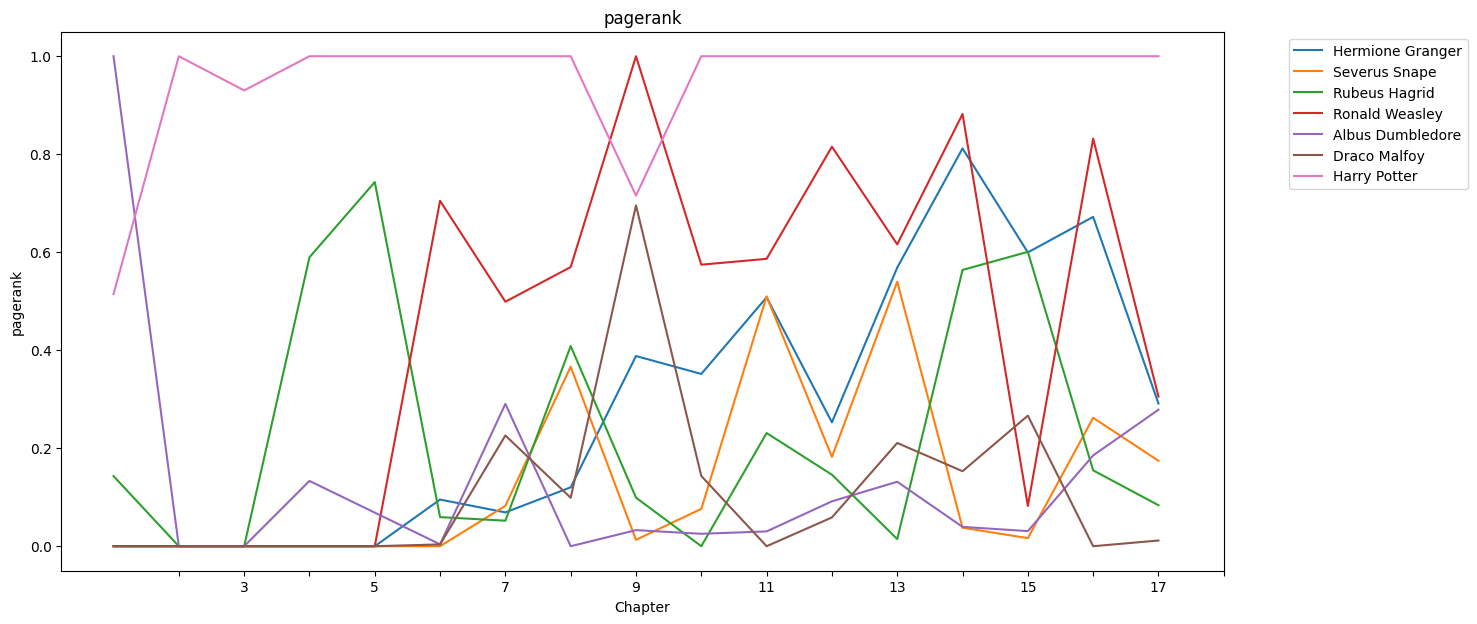

In [104]:
book.plot_metric_over_chapters("pagerank")

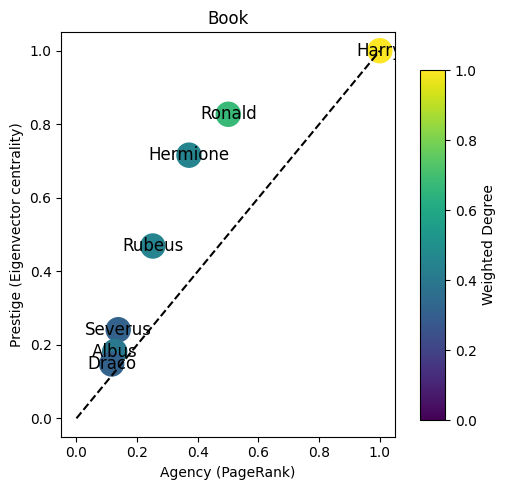

In [105]:
book.plot_centrality_diagram()